In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error

df = pd.read_csv('2016_Building_Energy_Benchmarking.csv')


In [61]:
# Importer le fichier CSV en tant que DataFrame df2
df2 = pd.read_csv('data_P4.csv')



# 1st feature engineering

## Prétraitement des données & Division des données en ensembles d'entraînement et de test.

In [62]:
# Diviser les données en features et target
X = df2[['NumberofFloors', 'Electricity(%)',
       'SteamUse(%)', 'NaturalGas(%)', 'Building_Age_Decades_Rounded', 'Nh_BALLARD',
       'Nh_CENTRAL', 'Nh_DELRIDGE', 'Nh_DOWNTOWN', 'Nh_EAST',
       'Nh_GREATER DUWAMISH', 'Nh_LAKE UNION', 'Nh_MAGNOLIA / QUEEN ANNE',
       'Nh_NORTH', 'Nh_NORTHEAST', 'Nh_NORTHWEST', 'Nh_SOUTHEAST',
       'Nh_SOUTHWEST', 'PropertyGFATotalSum', 'PropertyGFAParking(%)',
       'PropertyGFABuilding(s)(%)']]
y = np.log(df2['SiteEnergyUse(kBtu)'])

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#, 'CDC_1', 'CDC_2', 'CDC_3', 'CDC_4', 'CDC_5', 'CDC_6', 'CDC_7', 'NumberofBuildings', 

## Création de pipelines pour le prétraitement et la modélisation.

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet


# Création des pipelines
linear_pipeline = make_pipeline(StandardScaler(), ElasticNet())
random_forest_pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))
boosting_pipeline = make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=42))
svm_pipeline = make_pipeline(StandardScaler(), SVR(C=10))

## Utilisation de la validation croisée pour évaluer la performance des modèles.

In [64]:
# Définition de la métrique (R2 pour le coefficient de détermination)
def r2_cv(model, X, y):
    r2 = cross_val_score(model, X, y, scoring="r2", cv=5)
    return r2.mean()

# Évaluation des modèles en utilisant la validation croisée
linear_r2 = r2_cv(linear_pipeline, X_train, y_train)
random_forest_r2 = r2_cv(random_forest_pipeline, X_train, y_train)
boosting_r2 = r2_cv(boosting_pipeline, X_train, y_train)
svm_r2 = r2_cv(svm_pipeline, X_train, y_train)

print("R2 (Linear Regression):", linear_r2)
print("R2 (Random Forest):", random_forest_r2)
print("R2 (Gradient Boosting):", boosting_r2)
print("R2 (SVM):", svm_r2)


R2 (Linear Regression): 0.06708735748272832
R2 (Random Forest): 0.6064034736025719
R2 (Gradient Boosting): 0.6334854467837954
R2 (SVM): 0.5364206608541797


In [65]:
df2.columns


Index(['OSEBuildingID', 'BuildingType', 'CouncilDistrictCode',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'Electricity(%)', 'SteamUse(%)', 'NaturalGas(%)',
       'Building_Age_Decades_Rounded', 'CDC_1', 'CDC_2', 'CDC_3', 'CDC_4',
       'CDC_5', 'CDC_6', 'CDC_7', 'Nh_BALLARD', 'Nh_CENTRAL', 'Nh_DELRIDGE',
       'Nh_DOWNTOWN', 'Nh_EAST', 'Nh_GREATER DUWAMISH', 'Nh_LAKE UNION',
       'Nh_MAGNOLIA / QUEEN ANNE', 'Nh_NORTH', 'Nh_NORTHEAST', 'Nh_NORTHWEST',
       'Nh_SOUTHEAST', 'Nh_SOUTHWEST', 'PropertyGFATotalSum',
       'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)'],
      dtype='object')

## GridSearch

### Grid search sur gradient boosting

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Définir l'espace des paramètres pour GridSearch
param_grid = {
    'gradientboostingregressor__n_estimators': [100, 200, 300],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [3, 4, 5]
}

# Initialiser le modèle Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)

# Créer un pipeline
pipeline = make_pipeline(StandardScaler(), gb_model)

# Initialiser GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1)

# Ajuster GridSearchCV sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score R2:", grid_search.best_score_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Meilleurs paramètres: {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 100}
Meilleur score R2: 0.6334854467837954


### GridSearch sur Random forrest


In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Définir l'espace des paramètres pour GridSearch
param_grid_rf = {
    'randomforestregressor__n_estimators': [100, 200, 300], # Nombre d'arbres
    'randomforestregressor__max_depth': [None, 10, 20, 30], # Profondeur maximale de l'arbre
    'randomforestregressor__min_samples_split': [2, 5, 10], # Nombre minimum d'échantillons requis pour diviser un nœud
    'randomforestregressor__min_samples_leaf': [1, 2, 4] # Nombre minimum d'échantillons requis à chaque feuille
}

# Initialiser le modèle Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Créer un pipeline
pipeline_rf = make_pipeline(StandardScaler(), rf_model)

# Initialiser GridSearchCV
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='r2', verbose=1)

# Ajuster GridSearchCV sur les données d'entraînement
grid_search_rf.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres:", grid_search_rf.best_params_)
print("Meilleur score R2:", grid_search_rf.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs paramètres: {'randomforestregressor__max_depth': 10, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__n_estimators': 300}
Meilleur score R2: 0.6233114991878214


## Feature importance


In [68]:

# Accéder au modèle :
rf_model = grid_search_rf.best_estimator_.named_steps['randomforestregressor']

# Obtenir l'importance des caractéristiques
feature_importances = rf_model.feature_importances_

# Afficher l'importance de chaque caractéristique

feature_names = X.columns
importances = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Trier les caractéristiques par importance
importances = importances.sort_values(by='Importance', ascending=False)

print(importances)

                         Feature  Importance
18           PropertyGFATotalSum    0.801321
1                 Electricity(%)    0.060080
4   Building_Age_Decades_Rounded    0.029409
0                 NumberofFloors    0.027139
3                  NaturalGas(%)    0.025292
10           Nh_GREATER DUWAMISH    0.012715
20     PropertyGFABuilding(s)(%)    0.004717
14                  Nh_NORTHEAST    0.004518
19         PropertyGFAParking(%)    0.004514
17                  Nh_SOUTHWEST    0.004024
8                    Nh_DOWNTOWN    0.003646
9                        Nh_EAST    0.003480
12      Nh_MAGNOLIA / QUEEN ANNE    0.003339
5                     Nh_BALLARD    0.003188
2                    SteamUse(%)    0.003000
13                      Nh_NORTH    0.002438
7                    Nh_DELRIDGE    0.001893
11                 Nh_LAKE UNION    0.001756
15                  Nh_NORTHWEST    0.001690
6                     Nh_CENTRAL    0.001138
16                  Nh_SOUTHEAST    0.000704


# 2nd Feature Engineering

In [69]:
df['LargestPropertyUseType']


0                    Hotel
1                    Hotel
2                    Hotel
3                    Hotel
4                    Hotel
               ...        
3371                Office
3372    Other - Recreation
3373    Other - Recreation
3374    Other - Recreation
3375    Other - Recreation
Name: LargestPropertyUseType, Length: 3376, dtype: object

In [70]:
df2

,OSEBuildingID,BuildingType,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity(%),...,Nh_LAKE UNION,Nh_MAGNOLIA / QUEEN ANNE,Nh_NORTH,Nh_NORTHEAST,Nh_NORTHWEST,Nh_SOUTHEAST,Nh_SOUTHWEST,PropertyGFATotalSum,PropertyGFAParking(%),PropertyGFABuilding(s)(%)
0,1,NonResidential,7,1.0,12,0,88434,7.226362e+06,249.98,54.605997,...,0,0,0,0,0,0,0,88434,0.000000,100.000000
1,2,NonResidential,7,1.0,11,15064,88502,8.387933e+06,295.86,38.660907,...,0,0,0,0,0,0,0,103566,14.545314,85.454686
2,3,NonResidential,7,1.0,41,196718,759392,7.258702e+07,2089.28,68.230746,...,0,0,0,0,0,0,0,956110,20.574829,79.425171
3,5,NonResidential,7,1.0,10,0,61320,6.794584e+06,286.43,40.751933,...,0,0,0,0,0,0,0,61320,0.000000,100.000000
4,8,NonResidential,7,1.0,18,62000,113580,1.417261e+07,505.01,37.880171,...,0,0,0,0,0,0,0,175580,35.311539,64.688461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,50221,Nonresidential COS,1,1.0,1,0,18261,9.320821e+05,20.33,67.844031,...,0,0,0,0,0,0,0,18261,0.000000,100.000000
1543,50223,Nonresidential COS,2,1.0,1,0,16000,9.502762e+05,32.17,41.729565,...,0,0,0,0,0,0,0,16000,0.000000,100.000000
1544,50224,Nonresidential COS,7,1.0,1,0,13157,5.765898e+06,223.54,31.082042,...,0,1,0,0,0,0,0,13157,0.000000,100.000000
1545,50225,Nonresidential COS,1,1.0,1,0,14101,7.194712e+05,22.11,48.489806,...,0,0,0,0,0,0,0,14101,0.000000,100.000000


In [71]:
# Utilisation de merge pour ajouter la colonne LargestPropertyUseType à df2 en se basant sur OSEBuildingID
df2 = pd.merge(df2, df[['OSEBuildingID', 'LargestPropertyUseType']], on='OSEBuildingID', how='left')


In [72]:
df2[df2['LargestPropertyUseType'].isna()]

,OSEBuildingID,BuildingType,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity(%),...,Nh_MAGNOLIA / QUEEN ANNE,Nh_NORTH,Nh_NORTHEAST,Nh_NORTHWEST,Nh_SOUTHEAST,Nh_SOUTHWEST,PropertyGFATotalSum,PropertyGFAParking(%),PropertyGFABuilding(s)(%),LargestPropertyUseType
301,496,NonResidential,6,2.0,2,0,111445,5.697472e+06,163.83,52.786815,...,0,0,0,0,0,0,111445,0.0,100.0,NaN
753,21103,NonResidential,7,1.0,8,0,61721,2.897080e+06,36.92,87.487815,...,0,0,0,0,0,0,61721,0.0,100.0,NaN
1250,25568,NonResidential,4,1.0,4,0,48350,3.168131e+06,22.09,100.000000,...,0,0,0,0,0,0,48350,0.0,100.0,NaN
1267,25711,NonResidential,2,1.0,3,0,28800,8.999242e+05,29.21,44.771225,...,0,0,0,0,0,0,28800,0.0,100.0,NaN


In [73]:
# Suppression des lignes où LargestPropertyUseType est NaN dans df2
df2 = df2.dropna(subset=['LargestPropertyUseType'])


In [74]:
df2['LargestPropertyUseType'].value_counts()

LargestPropertyUseType
Office                                                  485
Non-Refrigerated Warehouse                              197
Other                                                    95
Retail Store                                             93
Hotel                                                    75
Worship Facility                                         69
Distribution Center                                      54
K-12 School                                              50
Medical Office                                           41
Supermarket/Grocery Store                                40
Other - Recreation                                       31
Parking                                                  30
Self-Storage Facility                                    27
College/University                                       24
Residence Hall/Dormitory                                 22
Other - Entertainment/Public Assembly                    21
Senior Care Commu

In [75]:
# Suppression des lignes où LargestPropertyUseType est 'Multifamily Housing' dans df2
df2 = df2.loc[df2['LargestPropertyUseType'] != 'Multifamily Housing']

In [76]:
df2['LargestPropertyUseType'].value_counts()

LargestPropertyUseType
Office                                                  485
Non-Refrigerated Warehouse                              197
Other                                                    95
Retail Store                                             93
Hotel                                                    75
Worship Facility                                         69
Distribution Center                                      54
K-12 School                                              50
Medical Office                                           41
Supermarket/Grocery Store                                40
Other - Recreation                                       31
Parking                                                  30
Self-Storage Facility                                    27
College/University                                       24
Residence Hall/Dormitory                                 22
Other - Entertainment/Public Assembly                    21
Senior Care Commu

In [77]:
def categorize_use_type_short(row):
    category_map_short = {
        'Office': 'Admin&Offices',
        'Financial Office': 'Admin&Offices',
        'Bank Branch': 'Admin&Offices',
        'Medical Office': 'Admin&Offices',
        'Non-Refrigerated Warehouse': 'Warehouses',
        'Refrigerated Warehouse': 'Warehouses',
        'Distribution Center': 'Warehouses',
        'Self-Storage Facility': 'Warehouses',
        'Retail Store': 'Retail',
        'Supermarket/Grocery Store': 'Retail',
        'Strip Mall': 'Retail',
        'Shopping Mall': 'Retail',
        'Automobile Dealership': 'Retail',
        'Wholesale Club/Supercenter': 'Retail',
        'K-12 School': 'Education',
        'College/University': 'Education',
        'Adult Education': 'Education',
        'Other - Education': 'Education',
        'Pre-school/Daycare': 'Education',
        'Hospital (General Medical & Surgical)': 'Health',
        'Senior Care Community': 'Health',
        'Residential Care Facility': 'Health',
        'Urgent Care/Clinic/Other Outpatient': 'Health',
        'Other/Specialty Hospital': 'Health',
        'Hotel': 'Leisure',
        'Residence Hall/Dormitory': 'Leisure',
        'Other - Lodging/Residential': 'Leisure',
        'Fitness Center/Health Club/Gym': 'Leisure',
        'Museum': 'Leisure',
        'Performing Arts': 'Leisure',
        'Movie Theater': 'Leisure',
        'Manufacturing/Industrial Plant': 'Industrial',
        'Laboratory': 'Industrial',
        'Data Center': 'Industrial',
        'Repair Services (Vehicle, Shoe, Locksmith, etc)': 'Industrial',
        'Worship Facility': 'Public',
        'Social/Meeting Hall': 'Public',
        'Police Station': 'Public',
        'Fire Station': 'Public',
        'Courthouse': 'Public',
        'Library': 'Public',
        'Prison/Incarceration': 'Public',
        'Restaurant': 'Other',
        'Other - Recreation': 'Other',
        'Other - Entertainment/Public Assembly': 'Other',
        'Other - Services': 'Other',
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': 'Other',
        'Other - Public Services': 'Other',
        'Other - Utility': 'Other',
        'Parking': 'Parking'
    }
    return category_map_short.get(row['LargestPropertyUseType'], 'Unknown')

# Mise à jour de df2 avec les noms de catégories raccourcis
df2['PrimaryUsageType'] = df2.apply(categorize_use_type_short, axis=1)


In [78]:
df2

,OSEBuildingID,BuildingType,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity(%),...,Nh_NORTH,Nh_NORTHEAST,Nh_NORTHWEST,Nh_SOUTHEAST,Nh_SOUTHWEST,PropertyGFATotalSum,PropertyGFAParking(%),PropertyGFABuilding(s)(%),LargestPropertyUseType,PrimaryUsageType
0,1,NonResidential,7,1.0,12,0,88434,7.226362e+06,249.98,54.605997,...,0,0,0,0,0,88434,0.000000,100.000000,Hotel,Leisure
1,2,NonResidential,7,1.0,11,15064,88502,8.387933e+06,295.86,38.660907,...,0,0,0,0,0,103566,14.545314,85.454686,Hotel,Leisure
2,3,NonResidential,7,1.0,41,196718,759392,7.258702e+07,2089.28,68.230746,...,0,0,0,0,0,956110,20.574829,79.425171,Hotel,Leisure
3,5,NonResidential,7,1.0,10,0,61320,6.794584e+06,286.43,40.751933,...,0,0,0,0,0,61320,0.000000,100.000000,Hotel,Leisure
4,8,NonResidential,7,1.0,18,62000,113580,1.417261e+07,505.01,37.880171,...,0,0,0,0,0,175580,35.311539,64.688461,Hotel,Leisure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,50221,Nonresidential COS,1,1.0,1,0,18261,9.320821e+05,20.33,67.844031,...,0,0,0,0,0,18261,0.000000,100.000000,Other - Recreation,Other
1543,50223,Nonresidential COS,2,1.0,1,0,16000,9.502762e+05,32.17,41.729565,...,0,0,0,0,0,16000,0.000000,100.000000,Other - Recreation,Other
1544,50224,Nonresidential COS,7,1.0,1,0,13157,5.765898e+06,223.54,31.082042,...,0,0,0,0,0,13157,0.000000,100.000000,Other - Recreation,Other
1545,50225,Nonresidential COS,1,1.0,1,0,14101,7.194712e+05,22.11,48.489806,...,0,0,0,0,0,14101,0.000000,100.000000,Other - Recreation,Other


In [79]:
# Effectuer un one hot encoding pour la colonne PrimaryUsageType dans df2
df2 = pd.get_dummies(df2, columns=['PrimaryUsageType'])


In [80]:
df2.columns

Index(['OSEBuildingID', 'BuildingType', 'CouncilDistrictCode',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'Electricity(%)', 'SteamUse(%)', 'NaturalGas(%)',
       'Building_Age_Decades_Rounded', 'CDC_1', 'CDC_2', 'CDC_3', 'CDC_4',
       'CDC_5', 'CDC_6', 'CDC_7', 'Nh_BALLARD', 'Nh_CENTRAL', 'Nh_DELRIDGE',
       'Nh_DOWNTOWN', 'Nh_EAST', 'Nh_GREATER DUWAMISH', 'Nh_LAKE UNION',
       'Nh_MAGNOLIA / QUEEN ANNE', 'Nh_NORTH', 'Nh_NORTHEAST', 'Nh_NORTHWEST',
       'Nh_SOUTHEAST', 'Nh_SOUTHWEST', 'PropertyGFATotalSum',
       'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)',
       'LargestPropertyUseType', 'PrimaryUsageType_Admin&Offices',
       'PrimaryUsageType_Education', 'PrimaryUsageType_Health',
       'PrimaryUsageType_Industrial', 'PrimaryUsageType_Leisure',
       'PrimaryUsageType_Other', 'PrimaryUsageType_Parking',
       'PrimaryUsageType_Public', 'PrimaryUsageTyp

In [81]:
columns_to_convert = [
    'PrimaryUsageType_Admin&Offices', 'PrimaryUsageType_Education',
    'PrimaryUsageType_Health', 'PrimaryUsageType_Industrial',
    'PrimaryUsageType_Leisure', 'PrimaryUsageType_Other',
    'PrimaryUsageType_Parking', 'PrimaryUsageType_Public',
    'PrimaryUsageType_Retail', 'PrimaryUsageType_Unknown',
    'PrimaryUsageType_Warehouses'
]

# Convertir les valeurs True/False en 1/0 pour les colonnes spécifiées
df2[columns_to_convert] = df2[columns_to_convert].astype(int)


In [82]:
df2

,OSEBuildingID,BuildingType,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity(%),...,PrimaryUsageType_Education,PrimaryUsageType_Health,PrimaryUsageType_Industrial,PrimaryUsageType_Leisure,PrimaryUsageType_Other,PrimaryUsageType_Parking,PrimaryUsageType_Public,PrimaryUsageType_Retail,PrimaryUsageType_Unknown,PrimaryUsageType_Warehouses
0,1,NonResidential,7,1.0,12,0,88434,7.226362e+06,249.98,54.605997,...,0,0,0,1,0,0,0,0,0,0
1,2,NonResidential,7,1.0,11,15064,88502,8.387933e+06,295.86,38.660907,...,0,0,0,1,0,0,0,0,0,0
2,3,NonResidential,7,1.0,41,196718,759392,7.258702e+07,2089.28,68.230746,...,0,0,0,1,0,0,0,0,0,0
3,5,NonResidential,7,1.0,10,0,61320,6.794584e+06,286.43,40.751933,...,0,0,0,1,0,0,0,0,0,0
4,8,NonResidential,7,1.0,18,62000,113580,1.417261e+07,505.01,37.880171,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,50221,Nonresidential COS,1,1.0,1,0,18261,9.320821e+05,20.33,67.844031,...,0,0,0,0,1,0,0,0,0,0
1543,50223,Nonresidential COS,2,1.0,1,0,16000,9.502762e+05,32.17,41.729565,...,0,0,0,0,1,0,0,0,0,0
1544,50224,Nonresidential COS,7,1.0,1,0,13157,5.765898e+06,223.54,31.082042,...,0,0,0,0,1,0,0,0,0,0
1545,50225,Nonresidential COS,1,1.0,1,0,14101,7.194712e+05,22.11,48.489806,...,0,0,0,0,1,0,0,0,0,0


## Prétraitement des données & Division des données en ensembles d'entraînement et de test & Pipelines

In [83]:
df2.columns


Index(['OSEBuildingID', 'BuildingType', 'CouncilDistrictCode',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'Electricity(%)', 'SteamUse(%)', 'NaturalGas(%)',
       'Building_Age_Decades_Rounded', 'CDC_1', 'CDC_2', 'CDC_3', 'CDC_4',
       'CDC_5', 'CDC_6', 'CDC_7', 'Nh_BALLARD', 'Nh_CENTRAL', 'Nh_DELRIDGE',
       'Nh_DOWNTOWN', 'Nh_EAST', 'Nh_GREATER DUWAMISH', 'Nh_LAKE UNION',
       'Nh_MAGNOLIA / QUEEN ANNE', 'Nh_NORTH', 'Nh_NORTHEAST', 'Nh_NORTHWEST',
       'Nh_SOUTHEAST', 'Nh_SOUTHWEST', 'PropertyGFATotalSum',
       'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)',
       'LargestPropertyUseType', 'PrimaryUsageType_Admin&Offices',
       'PrimaryUsageType_Education', 'PrimaryUsageType_Health',
       'PrimaryUsageType_Industrial', 'PrimaryUsageType_Leisure',
       'PrimaryUsageType_Other', 'PrimaryUsageType_Parking',
       'PrimaryUsageType_Public', 'PrimaryUsageTyp

In [84]:
# Diviser les données en features et target
X = df2[['NumberofFloors', 'Electricity(%)',
       'SteamUse(%)', 'NaturalGas(%)', 'Building_Age_Decades_Rounded', 'Nh_BALLARD',
       'Nh_CENTRAL', 'Nh_DELRIDGE', 'Nh_DOWNTOWN', 'Nh_EAST',
       'Nh_GREATER DUWAMISH', 'Nh_LAKE UNION', 'Nh_MAGNOLIA / QUEEN ANNE',
       'Nh_NORTH', 'Nh_NORTHEAST', 'Nh_NORTHWEST', 'Nh_SOUTHEAST',
       'Nh_SOUTHWEST', 'PropertyGFATotalSum', 'PropertyGFAParking(%)',
       'PropertyGFABuilding(s)(%)', 'PrimaryUsageType_Admin&Offices', 'PrimaryUsageType_Education',
       'PrimaryUsageType_Health', 'PrimaryUsageType_Industrial',
       'PrimaryUsageType_Leisure', 'PrimaryUsageType_Other',
       'PrimaryUsageType_Parking', 'PrimaryUsageType_Public',
       'PrimaryUsageType_Retail', 'PrimaryUsageType_Unknown',
       'PrimaryUsageType_Warehouses']]
y = np.log(df2['SiteEnergyUse(kBtu)'])

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#, 'CDC_1', 'CDC_2', 'CDC_3', 'CDC_4', 'CDC_5', 'CDC_6', 'CDC_7', 'NumberofBuildings', 


from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet


# Création des pipelines
linear_pipeline = make_pipeline(StandardScaler(), ElasticNet())
random_forest_pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))
boosting_pipeline = make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=42))
svm_pipeline = make_pipeline(StandardScaler(), SVR(C=10))

# Définition de la métrique (R2 pour le coefficient de détermination)
def r2_cv(model, X, y):
    r2 = cross_val_score(model, X, y, scoring="r2", cv=5)
    return r2.mean()

# Évaluation des modèles en utilisant la validation croisée
linear_r2 = r2_cv(linear_pipeline, X_train, y_train)
random_forest_r2 = r2_cv(random_forest_pipeline, X_train, y_train)
boosting_r2 = r2_cv(boosting_pipeline, X_train, y_train)
svm_r2 = r2_cv(svm_pipeline, X_train, y_train)

print("R2 (Linear Regression):", linear_r2)
print("R2 (Random Forest):", random_forest_r2)
print("R2 (Gradient Boosting):", boosting_r2)
print("R2 (SVM):", svm_r2)


R2 (Linear Regression): 0.06538377193865039
R2 (Random Forest): 0.7153104569741814
R2 (Gradient Boosting): 0.7333652884935007
R2 (SVM): 0.562877705816862


## GridSearch

In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Définir l'espace des paramètres pour GridSearch
param_grid = {
    'gradientboostingregressor__n_estimators': [100, 200, 300],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [3, 4, 5]
}

# Initialiser le modèle Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)

# Créer un pipeline
pipeline = make_pipeline(StandardScaler(), gb_model)

# Initialiser GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1)

# Ajuster GridSearchCV sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score R2:", grid_search.best_score_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Meilleurs paramètres: {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 100}
Meilleur score R2: 0.7333652884935007


In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Définir l'espace des paramètres pour GridSearch
param_grid_rf = {
    'randomforestregressor__n_estimators': [100, 200, 300], # Nombre d'arbres
    'randomforestregressor__max_depth': [None, 10, 20, 30], # Profondeur maximale de l'arbre
    'randomforestregressor__min_samples_split': [2, 5, 10], # Nombre minimum d'échantillons requis pour diviser un nœud
    'randomforestregressor__min_samples_leaf': [1, 2, 4] # Nombre minimum d'échantillons requis à chaque feuille
}

# Initialiser le modèle Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Créer un pipeline 
pipeline_rf = make_pipeline(StandardScaler(), rf_model)

# Initialiser GridSearchCV
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='r2', verbose=1)

# Ajuster GridSearchCV sur les données d'entraînement
grid_search_rf.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres:", grid_search_rf.best_params_)
print("Meilleur score R2:", grid_search_rf.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs paramètres: {'randomforestregressor__max_depth': 10, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__n_estimators': 100}
Meilleur score R2: 0.7216318910530559


## Feature Importance


In [87]:

# Accéder au modèle :
rf_model = grid_search_rf.best_estimator_.named_steps['randomforestregressor']

# Obtenir l'importance des caractéristiques
feature_importances = rf_model.feature_importances_

# Afficher l'importance de chaque caractéristique

feature_names = X.columns
importances = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Trier les caractéristiques par importance
importances = importances.sort_values(by='Importance', ascending=False)

print(importances)

                           Feature  Importance
18             PropertyGFATotalSum    0.743903
31     PrimaryUsageType_Warehouses    0.064104
1                   Electricity(%)    0.039883
3                    NaturalGas(%)    0.022135
4     Building_Age_Decades_Rounded    0.021324
24     PrimaryUsageType_Industrial    0.012967
0                   NumberofFloors    0.011246
23         PrimaryUsageType_Health    0.009737
29         PrimaryUsageType_Retail    0.008430
21  PrimaryUsageType_Admin&Offices    0.007015
26          PrimaryUsageType_Other    0.006040
10             Nh_GREATER DUWAMISH    0.005719
28         PrimaryUsageType_Public    0.005276
20       PropertyGFABuilding(s)(%)    0.004883
30        PrimaryUsageType_Unknown    0.004308
19           PropertyGFAParking(%)    0.004185
13                        Nh_NORTH    0.003411
7                      Nh_DELRIDGE    0.003287
14                    Nh_NORTHEAST    0.002998
12        Nh_MAGNOLIA / QUEEN ANNE    0.002244
2            

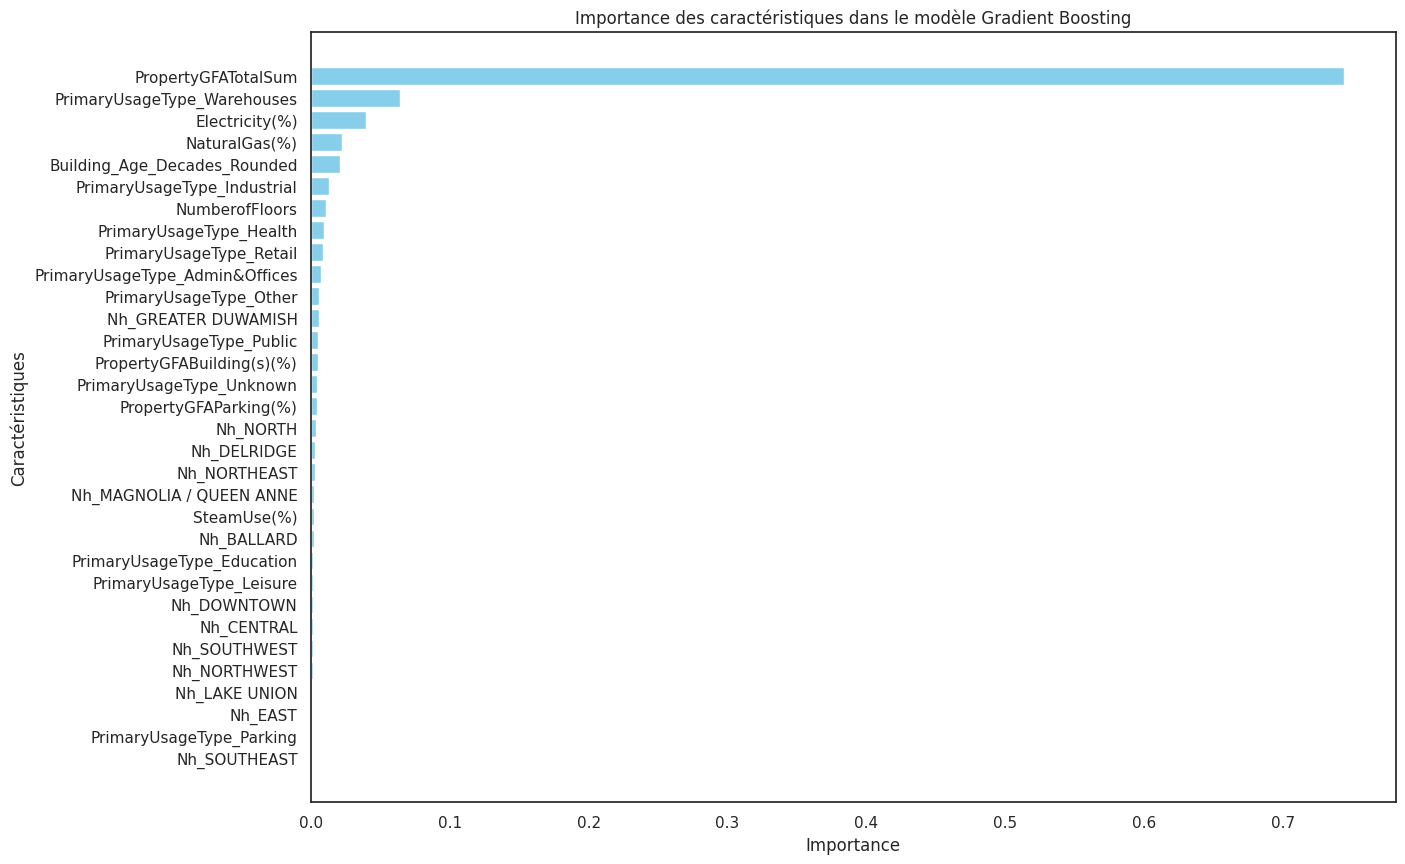

In [88]:
# Tracer le graphique d'importance des caractéristiques
plt.figure(figsize=(14, 10))  # Définir la taille de la figure
plt.barh(importances['Feature'], importances['Importance'], color='skyblue')  # Tracer les barres horizontales
plt.xlabel('Importance')  # Étiquette de l'axe des x
plt.ylabel('Caractéristiques')  # Étiquette de l'axe des y
plt.title('Importance des caractéristiques dans le modèle Gradient Boosting')  # Titre du graphique
plt.gca().invert_yaxis()  # Inverser l'axe y pour que les caractéristiques les plus importantes soient en haut
plt.show()  # Afficher le graphique


In [89]:
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

## Feature importance locale

In [90]:
import shap

explainer = shap.Explainer(gb_model)


In [91]:
shap_values = explainer.shap_values(X_test)

In [92]:
print(shap_values[0])
print(X_test)



[-1.06194645e-02  1.45850299e-01 -5.71715940e-03  6.74280180e-02
  7.74443540e-02 -4.53872691e-04 -1.34898429e-04  0.00000000e+00
 -1.30501138e-02  0.00000000e+00 -3.13516831e-03 -3.67053535e-05
  4.53921860e-04 -4.15296398e-02 -1.10904340e-02  2.99785692e-04
  2.50010262e-05 -6.85872790e-03 -6.31181611e-01  2.38129970e-03
 -1.07137022e-03  2.22710106e-02  6.77830889e-03 -9.25781284e-03
 -1.20460138e-02 -7.11084032e-05  1.87068606e-01  1.78626829e-04
  3.64265561e-02 -2.68137095e-02 -8.83900273e-03  1.76892563e-01]
      NumberofFloors  Electricity(%)  SteamUse(%)  NaturalGas(%)  \
894                1       46.570351     0.000000      53.429649   
76                 3      100.000000     0.000000       0.000000   
318                3      100.000000     0.000000       0.000000   
667               15      100.000000     0.000000       0.000000   
573                3       57.686818     0.000000      42.313182   
...              ...             ...          ...            ...   
118

In [93]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.values[0], feature_names = X_test.columns)


# Ajout Energy Star Score

In [94]:
df2

,OSEBuildingID,BuildingType,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity(%),...,PrimaryUsageType_Education,PrimaryUsageType_Health,PrimaryUsageType_Industrial,PrimaryUsageType_Leisure,PrimaryUsageType_Other,PrimaryUsageType_Parking,PrimaryUsageType_Public,PrimaryUsageType_Retail,PrimaryUsageType_Unknown,PrimaryUsageType_Warehouses
0,1,NonResidential,7,1.0,12,0,88434,7.226362e+06,249.98,54.605997,...,0,0,0,1,0,0,0,0,0,0
1,2,NonResidential,7,1.0,11,15064,88502,8.387933e+06,295.86,38.660907,...,0,0,0,1,0,0,0,0,0,0
2,3,NonResidential,7,1.0,41,196718,759392,7.258702e+07,2089.28,68.230746,...,0,0,0,1,0,0,0,0,0,0
3,5,NonResidential,7,1.0,10,0,61320,6.794584e+06,286.43,40.751933,...,0,0,0,1,0,0,0,0,0,0
4,8,NonResidential,7,1.0,18,62000,113580,1.417261e+07,505.01,37.880171,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,50221,Nonresidential COS,1,1.0,1,0,18261,9.320821e+05,20.33,67.844031,...,0,0,0,0,1,0,0,0,0,0
1543,50223,Nonresidential COS,2,1.0,1,0,16000,9.502762e+05,32.17,41.729565,...,0,0,0,0,1,0,0,0,0,0
1544,50224,Nonresidential COS,7,1.0,1,0,13157,5.765898e+06,223.54,31.082042,...,0,0,0,0,1,0,0,0,0,0
1545,50225,Nonresidential COS,1,1.0,1,0,14101,7.194712e+05,22.11,48.489806,...,0,0,0,0,1,0,0,0,0,0


In [95]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [96]:
df[['OSEBuildingID', 'ENERGYSTARScore']]

,OSEBuildingID,ENERGYSTARScore
0,1,60.0
1,2,61.0
2,3,43.0
3,5,56.0
4,8,75.0
...,...,...
3371,50222,46.0
3372,50223,NaN
3373,50224,NaN
3374,50225,NaN


In [97]:

# Utilisation de la fonction merge pour ajouter la colonne 'ENERGYSTARScore' dans df2
df3 = df2.merge(df[['OSEBuildingID', 'ENERGYSTARScore']], on='OSEBuildingID', how='left')

In [98]:
df3 

,OSEBuildingID,BuildingType,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity(%),...,PrimaryUsageType_Health,PrimaryUsageType_Industrial,PrimaryUsageType_Leisure,PrimaryUsageType_Other,PrimaryUsageType_Parking,PrimaryUsageType_Public,PrimaryUsageType_Retail,PrimaryUsageType_Unknown,PrimaryUsageType_Warehouses,ENERGYSTARScore
0,1,NonResidential,7,1.0,12,0,88434,7.226362e+06,249.98,54.605997,...,0,0,1,0,0,0,0,0,0,60.0
1,2,NonResidential,7,1.0,11,15064,88502,8.387933e+06,295.86,38.660907,...,0,0,1,0,0,0,0,0,0,61.0
2,3,NonResidential,7,1.0,41,196718,759392,7.258702e+07,2089.28,68.230746,...,0,0,1,0,0,0,0,0,0,43.0
3,5,NonResidential,7,1.0,10,0,61320,6.794584e+06,286.43,40.751933,...,0,0,1,0,0,0,0,0,0,56.0
4,8,NonResidential,7,1.0,18,62000,113580,1.417261e+07,505.01,37.880171,...,0,0,1,0,0,0,0,0,0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527,50221,Nonresidential COS,1,1.0,1,0,18261,9.320821e+05,20.33,67.844031,...,0,0,0,1,0,0,0,0,0,NaN
1528,50223,Nonresidential COS,2,1.0,1,0,16000,9.502762e+05,32.17,41.729565,...,0,0,0,1,0,0,0,0,0,NaN
1529,50224,Nonresidential COS,7,1.0,1,0,13157,5.765898e+06,223.54,31.082042,...,0,0,0,1,0,0,0,0,0,NaN
1530,50225,Nonresidential COS,1,1.0,1,0,14101,7.194712e+05,22.11,48.489806,...,0,0,0,1,0,0,0,0,0,NaN


In [99]:
df3['ENERGYSTARScore'].isna().sum()

542

In [100]:
df3.shape

(1532, 49)

In [101]:
df3[['PropertyGFATotalSum', 'PrimaryUsageType_Warehouses', 'Electricity(%)', 'NaturalGas(%)', 'Building_Age_Decades_Rounded', 'PrimaryUsageType_Industrial', 'NumberofFloors', 'ENERGYSTARScore']]

,PropertyGFATotalSum,PrimaryUsageType_Warehouses,Electricity(%),NaturalGas(%),Building_Age_Decades_Rounded,PrimaryUsageType_Industrial,NumberofFloors,ENERGYSTARScore
0,88434,0,54.605997,17.663840,10.0,0,12,60.0
1,103566,0,38.660907,61.339093,3.0,0,11,61.0
2,956110,0,68.230746,2.057944,6.0,0,41,43.0
3,61320,0,40.751933,26.656720,10.0,0,10,56.0
4,175580,0,37.880171,62.119829,4.0,0,18,75.0
...,...,...,...,...,...,...,...,...
1527,18261,0,67.844031,32.155969,4.0,0,1,NaN
1528,16000,0,41.729565,58.270435,2.0,0,1,NaN
1529,13157,0,31.082042,68.917958,5.0,0,1,NaN
1530,14101,0,48.489806,51.510194,4.0,0,1,NaN


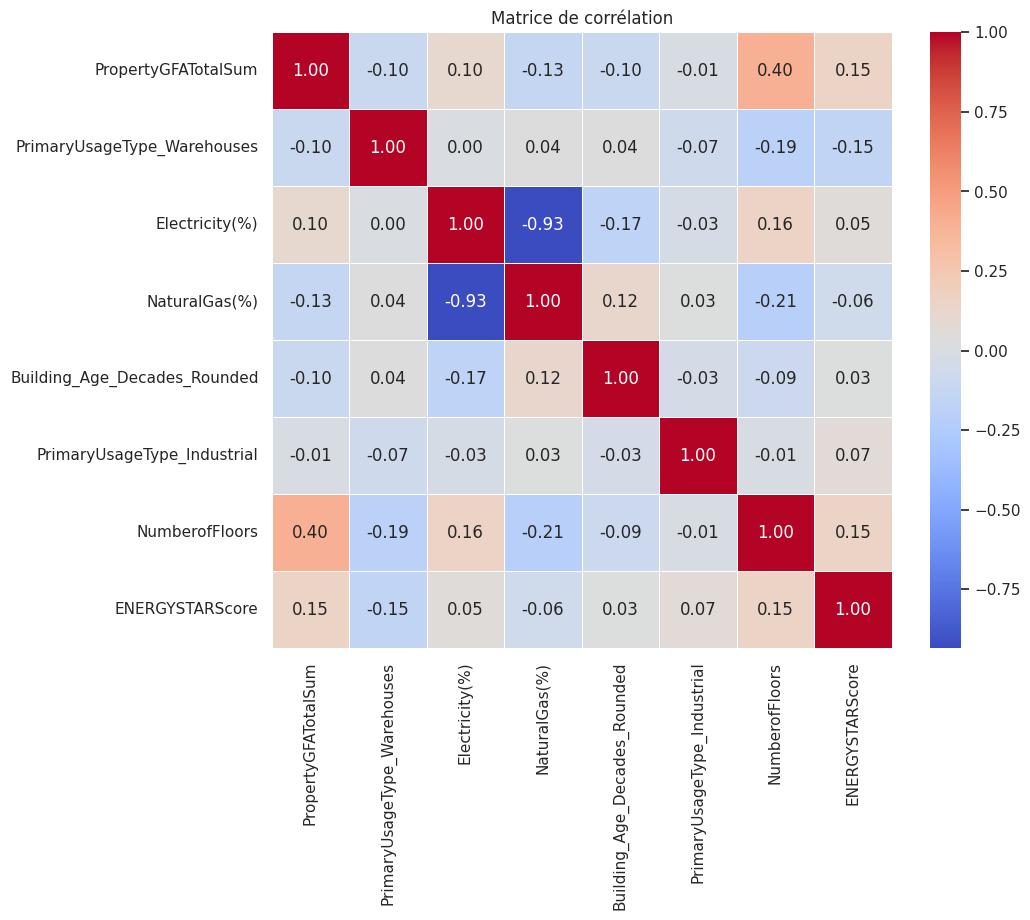

In [102]:
# Calcul de la matrice de corrélation
corr = df3[['PropertyGFATotalSum', 'PrimaryUsageType_Warehouses', 'Electricity(%)', 'NaturalGas(%)', 'Building_Age_Decades_Rounded', 'PrimaryUsageType_Industrial', 'NumberofFloors', 'ENERGYSTARScore']].corr()

# Configuration de Seaborn pour une meilleure apparence
sns.set(style="white")

# Création de la matrice de corrélation avec Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation")
plt.show()

In [103]:
# Supprimer les lignes avec des valeurs NaN dans la colonne 'ENERGYSTARScore'
df3 = df3.dropna(subset=['ENERGYSTARScore'])

In [104]:
df3

,OSEBuildingID,BuildingType,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity(%),...,PrimaryUsageType_Health,PrimaryUsageType_Industrial,PrimaryUsageType_Leisure,PrimaryUsageType_Other,PrimaryUsageType_Parking,PrimaryUsageType_Public,PrimaryUsageType_Retail,PrimaryUsageType_Unknown,PrimaryUsageType_Warehouses,ENERGYSTARScore
0,1,NonResidential,7,1.0,12,0,88434,7226362.50,249.98,54.605997,...,0,0,1,0,0,0,0,0,0,60.0
1,2,NonResidential,7,1.0,11,15064,88502,8387933.00,295.86,38.660907,...,0,0,1,0,0,0,0,0,0,61.0
2,3,NonResidential,7,1.0,41,196718,759392,72587024.00,2089.28,68.230746,...,0,0,1,0,0,0,0,0,0,43.0
3,5,NonResidential,7,1.0,10,0,61320,6794584.00,286.43,40.751933,...,0,0,1,0,0,0,0,0,0,56.0
4,8,NonResidential,7,1.0,18,62000,113580,14172606.00,505.01,37.880171,...,0,0,1,0,0,0,0,0,0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,50054,Nonresidential COS,7,1.0,13,197659,339038,13239050.00,245.16,74.973435,...,0,0,0,0,0,0,0,0,0,98.0
1512,50062,NonResidential,4,1.0,4,41539,85284,6042399.50,131.02,68.112351,...,0,0,1,0,0,0,0,0,0,72.0
1513,50068,NonResidential,2,1.0,1,4222,47863,3605855.50,157.70,20.322586,...,0,0,0,0,0,0,0,0,1,37.0
1514,50069,NonResidential,2,1.0,2,0,24990,4420650.50,134.80,49.020597,...,0,0,0,0,0,0,0,0,0,9.0


## Prétraitement des données & Division des données en ensembles d'entraînement et de test & Pipelines

In [105]:
# Diviser les données en features et target
X = df3[['NumberofFloors', 'Electricity(%)',
       'SteamUse(%)', 'NaturalGas(%)', 'Building_Age_Decades_Rounded', 'Nh_BALLARD',
       'Nh_CENTRAL', 'Nh_DELRIDGE', 'Nh_DOWNTOWN', 'Nh_EAST',
       'Nh_GREATER DUWAMISH', 'Nh_LAKE UNION', 'Nh_MAGNOLIA / QUEEN ANNE',
       'Nh_NORTH', 'Nh_NORTHEAST', 'Nh_NORTHWEST', 'Nh_SOUTHEAST',
       'Nh_SOUTHWEST', 'PropertyGFATotalSum', 'PropertyGFAParking(%)',
       'PropertyGFABuilding(s)(%)', 'PrimaryUsageType_Admin&Offices', 'PrimaryUsageType_Education',
       'PrimaryUsageType_Health', 'PrimaryUsageType_Industrial',
       'PrimaryUsageType_Leisure', 'PrimaryUsageType_Other',
       'PrimaryUsageType_Parking', 'PrimaryUsageType_Public',
       'PrimaryUsageType_Retail', 'PrimaryUsageType_Unknown',
       'PrimaryUsageType_Warehouses', 'ENERGYSTARScore']]
y = np.log(df3['SiteEnergyUse(kBtu)'])

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#, 'CDC_1', 'CDC_2', 'CDC_3', 'CDC_4', 'CDC_5', 'CDC_6', 'CDC_7', 'NumberofBuildings', 


from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet


# Création des pipelines
linear_pipeline = make_pipeline(StandardScaler(), ElasticNet())
random_forest_pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))
boosting_pipeline = make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=42))
svm_pipeline = make_pipeline(StandardScaler(), SVR(C=10))

# Définition de la métrique (R2 pour le coefficient de détermination)
def r2_cv(model, X, y):
    r2 = cross_val_score(model, X, y, scoring="r2", cv=5)
    return r2.mean()

# Évaluation des modèles en utilisant la validation croisée
linear_r2 = r2_cv(linear_pipeline, X_train, y_train)
random_forest_r2 = r2_cv(random_forest_pipeline, X_train, y_train)
boosting_r2 = r2_cv(boosting_pipeline, X_train, y_train)
svm_r2 = r2_cv(svm_pipeline, X_train, y_train)

print("R2 (Linear Regression):", linear_r2)
print("R2 (Random Forest):", random_forest_r2)
print("R2 (Gradient Boosting):", boosting_r2)
print("R2 (SVM):", svm_r2)


R2 (Linear Regression): 0.19889666792042054
R2 (Random Forest): 0.8228217976834088
R2 (Gradient Boosting): 0.8665238236921844
R2 (SVM): 0.7272602473634213


## GridSearch

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Définir l'espace des paramètres pour GridSearch
param_grid = {
    'gradientboostingregressor__n_estimators': [100, 200, 300],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [3, 4, 5]
}

# Initialiser le modèle Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)

# Créer un pipeline 
pipeline = make_pipeline(StandardScaler(), gb_model)

# Initialiser GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1)

# Ajuster GridSearchCV sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score R2:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Meilleurs paramètres: {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 200}
Meilleur score R2: 0.8698920673093617


## Feature Importance

In [107]:
# Ajuster le modèle Gradient Boosting avec les meilleurs paramètres trouvés par GridSearchCV
best_gb_model = grid_search.best_estimator_

# Ajuster le modèle sur les données d'entraînement
best_gb_model.fit(X_train, y_train)

# Obtenir l'importance des caractéristiques
feature_importance = best_gb_model.named_steps['gradientboostingregressor'].feature_importances_

# Créer une DataFrame pour stocker l'importance des caractéristiques avec leurs noms
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Trier les caractéristiques par importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Afficher l'importance des caractéristiques
print(feature_importance_df)


                           Feature  Importance
18             PropertyGFATotalSum    0.698444
32                 ENERGYSTARScore    0.106225
31     PrimaryUsageType_Warehouses    0.075181
1                   Electricity(%)    0.031924
29         PrimaryUsageType_Retail    0.018648
24     PrimaryUsageType_Industrial    0.013236
28         PrimaryUsageType_Public    0.009675
3                    NaturalGas(%)    0.008408
4     Building_Age_Decades_Rounded    0.006928
0                   NumberofFloors    0.006045
23         PrimaryUsageType_Health    0.005652
19           PropertyGFAParking(%)    0.003918
20       PropertyGFABuilding(s)(%)    0.003144
27        PrimaryUsageType_Parking    0.002491
17                    Nh_SOUTHWEST    0.002458
11                   Nh_LAKE UNION    0.001390
5                       Nh_BALLARD    0.000970
16                    Nh_SOUTHEAST    0.000834
15                    Nh_NORTHWEST    0.000801
21  PrimaryUsageType_Admin&Offices    0.000751
10           

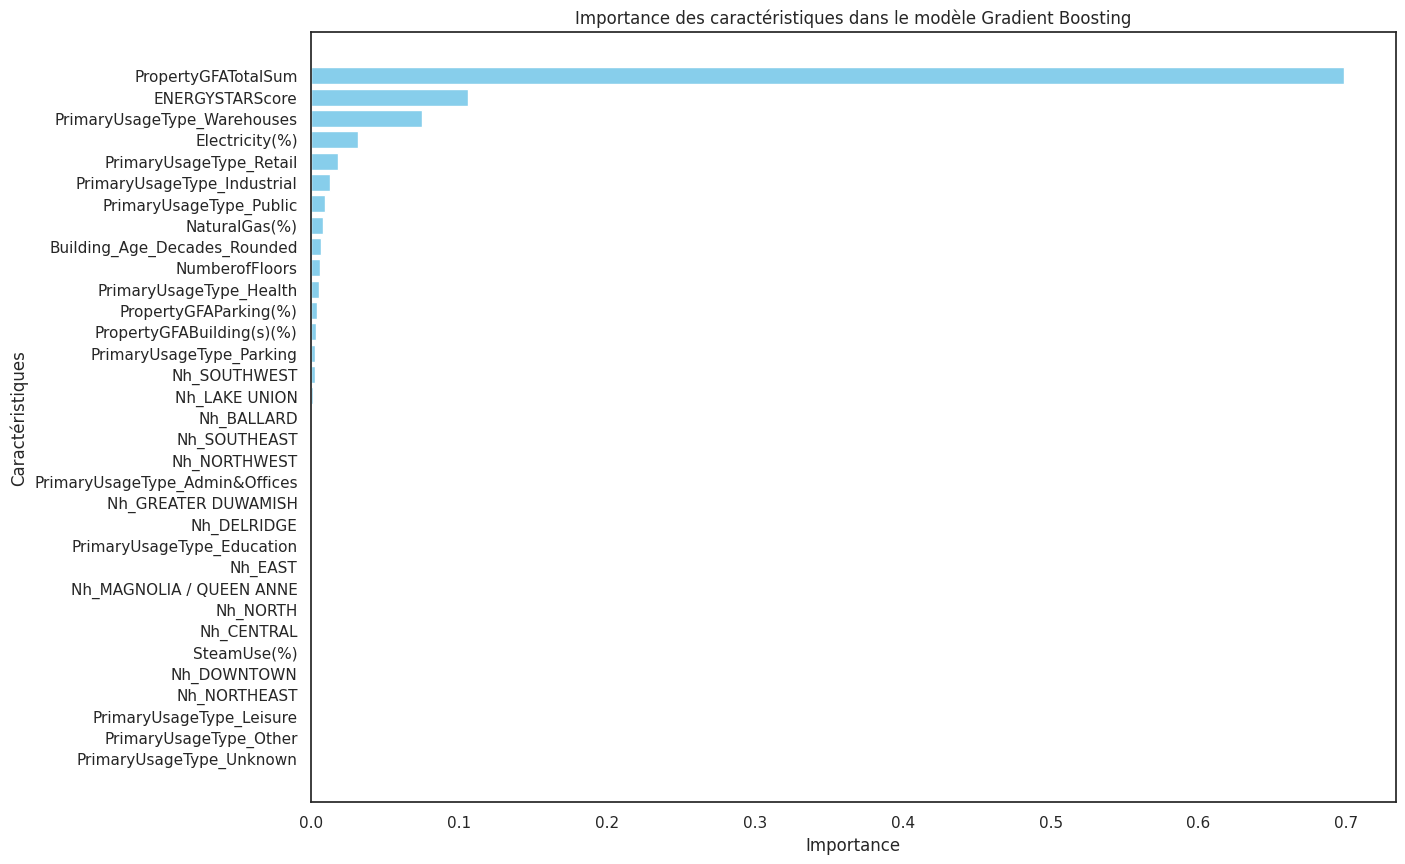

In [108]:

# Tracer le graphique d'importance des caractéristiques
plt.figure(figsize=(14, 10))  # Définir la taille de la figure
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')  # Tracer les barres horizontales
plt.xlabel('Importance')  # Étiquette de l'axe des x
plt.ylabel('Caractéristiques')  # Étiquette de l'axe des y
plt.title('Importance des caractéristiques dans le modèle Gradient Boosting')  # Titre du graphique
plt.gca().invert_yaxis()  # Inverser l'axe y pour que les caractéristiques les plus importantes soient en haut
plt.show()  # Afficher le graphique


In [109]:
df3

,OSEBuildingID,BuildingType,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUse(kBtu),TotalGHGEmissions,Electricity(%),...,PrimaryUsageType_Health,PrimaryUsageType_Industrial,PrimaryUsageType_Leisure,PrimaryUsageType_Other,PrimaryUsageType_Parking,PrimaryUsageType_Public,PrimaryUsageType_Retail,PrimaryUsageType_Unknown,PrimaryUsageType_Warehouses,ENERGYSTARScore
0,1,NonResidential,7,1.0,12,0,88434,7226362.50,249.98,54.605997,...,0,0,1,0,0,0,0,0,0,60.0
1,2,NonResidential,7,1.0,11,15064,88502,8387933.00,295.86,38.660907,...,0,0,1,0,0,0,0,0,0,61.0
2,3,NonResidential,7,1.0,41,196718,759392,72587024.00,2089.28,68.230746,...,0,0,1,0,0,0,0,0,0,43.0
3,5,NonResidential,7,1.0,10,0,61320,6794584.00,286.43,40.751933,...,0,0,1,0,0,0,0,0,0,56.0
4,8,NonResidential,7,1.0,18,62000,113580,14172606.00,505.01,37.880171,...,0,0,1,0,0,0,0,0,0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,50054,Nonresidential COS,7,1.0,13,197659,339038,13239050.00,245.16,74.973435,...,0,0,0,0,0,0,0,0,0,98.0
1512,50062,NonResidential,4,1.0,4,41539,85284,6042399.50,131.02,68.112351,...,0,0,1,0,0,0,0,0,0,72.0
1513,50068,NonResidential,2,1.0,1,4222,47863,3605855.50,157.70,20.322586,...,0,0,0,0,0,0,0,0,1,37.0
1514,50069,NonResidential,2,1.0,2,0,24990,4420650.50,134.80,49.020597,...,0,0,0,0,0,0,0,0,0,9.0


In [110]:
df_corr = df3[['NumberofFloors', 'Electricity(%)',
       'SteamUse(%)', 'NaturalGas(%)', 'Building_Age_Decades_Rounded', 'Nh_BALLARD',
       'Nh_CENTRAL', 'Nh_DELRIDGE', 'Nh_DOWNTOWN', 'Nh_EAST',
       'Nh_GREATER DUWAMISH', 'Nh_LAKE UNION', 'Nh_MAGNOLIA / QUEEN ANNE',
       'Nh_NORTH', 'Nh_NORTHEAST', 'Nh_NORTHWEST', 'Nh_SOUTHEAST',
       'Nh_SOUTHWEST', 'PropertyGFATotalSum', 'PropertyGFAParking(%)',
       'PropertyGFABuilding(s)(%)', 'PrimaryUsageType_Admin&Offices', 'PrimaryUsageType_Education',
       'PrimaryUsageType_Health', 'PrimaryUsageType_Industrial',
       'PrimaryUsageType_Leisure', 'PrimaryUsageType_Other',
       'PrimaryUsageType_Parking', 'PrimaryUsageType_Public',
       'PrimaryUsageType_Retail', 'PrimaryUsageType_Unknown',
       'PrimaryUsageType_Warehouses', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)']]

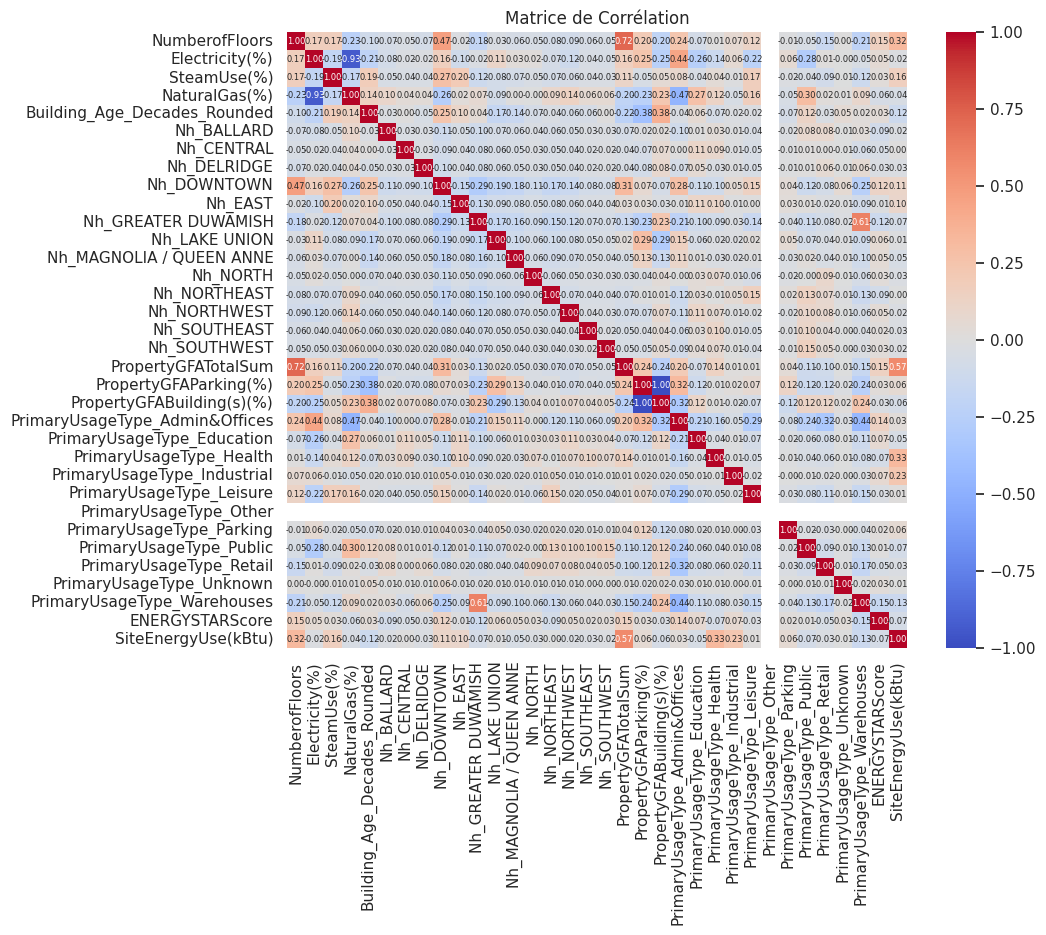

In [111]:

correlation_matrix = df_corr.corr()



# Visualiser la matrice de corrélation avec une heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True,
            annot_kws={"size": 6})  # Réglage de la taille du texte des annotations
plt.title('Matrice de Corrélation')
plt.show()
